## Recognition of hand drawings with CNNs and using the dataset of Quick-Draw API

* Minor Applied Artificial Intelligence HvA
* Aghead Bilal

### Importing packages

In [2]:
import datetime, os
import tensorflow as tf

from pathlib import Path
from matplotlib import pyplot as plt
from quickdraw import QuickDrawDataGroup, QuickDrawData

from tensorflow.keras.preprocessing import image_dataset_from_directory

from tensorflow.keras.models import Sequential
from tensorflow.keras.losses import SparseCategoricalCrossentropy
from tensorflow.keras.metrics import sparse_categorical_accuracy
from tensorflow.keras.layers.experimental.preprocessing import Rescaling
from tensorflow.keras.layers import Dense, Flatten, Conv2D, MaxPooling2D, Dropout, BatchNormalization

from tensorflow.keras.callbacks import TensorBoard

### Dataset generation

In [3]:
image_size = (28, 28)

To train the neural network, we generate our own dataset by making slight modifications to the Google dataset. <br>
We will employee a Python package called quickdraw to download and access the dataset from the Google Cloud Platform.

In [3]:
# Load 1200 training images for each class from the cloud storage
# Resize each image to 28x28 pixels
# Save the resized images in PNG format
def generate_class_images(name, max_drawings, recognized):
    directory = Path("dataset/" + name)

    if not directory.exists():
        directory.mkdir(parents=True)

    # If recognized=True is set, it guarantees that only images recognized by Google's AI will be loaded.
    images = QuickDrawDataGroup(name, max_drawings=max_drawings, recognized=recognized)
    for img in images.drawings:
        filename = directory.as_posix() + "/" + str(img.key_id) + ".png"
        img.get_image(stroke_width=3).resize(image_size).save(filename)

for label in QuickDrawData().drawing_names:
    generate_class_images(label, max_drawings=1200, recognized=True)

downloading aircraft carrier from https://storage.googleapis.com/quickdraw_dataset/full/binary/aircraft carrier.bin
download complete
loading aircraft carrier drawings
load complete
downloading airplane from https://storage.googleapis.com/quickdraw_dataset/full/binary/airplane.bin
download complete
loading airplane drawings
load complete
downloading alarm clock from https://storage.googleapis.com/quickdraw_dataset/full/binary/alarm clock.bin
download complete
loading alarm clock drawings
load complete
downloading ambulance from https://storage.googleapis.com/quickdraw_dataset/full/binary/ambulance.bin
download complete
loading ambulance drawings
load complete
downloading angel from https://storage.googleapis.com/quickdraw_dataset/full/binary/angel.bin
download complete
loading angel drawings
load complete
downloading animal migration from https://storage.googleapis.com/quickdraw_dataset/full/binary/animal migration.bin
download complete
loading animal migration drawings
load complete
d

### Dataset loading/splitting

The images will be loaded using the Keras image_dataset_from_directory function and will then be divided into training and validation sets.

In [4]:
# Batch size is a hyperparameter that determines the number of training examples used in one iteration
batch_size = 32 

# The dataset will be split into an 80% training set and a 20% validation set.
train_ds = image_dataset_from_directory(
    "dataset",
    validation_split=0.2,
    subset="training",
    seed=123,
    color_mode="grayscale",
    image_size=image_size,
    batch_size=batch_size
)

val_ds = image_dataset_from_directory(
    "dataset",
    validation_split=0.2,
    subset="validation",
    seed=123,
    color_mode="grayscale",
    image_size=image_size,
    batch_size=batch_size
)

Found 414000 files belonging to 345 classes.
Using 331200 files for training.
Found 414000 files belonging to 345 classes.
Using 82800 files for validation.


### Visualization

After we split the dataset, let's visualize some random training images.

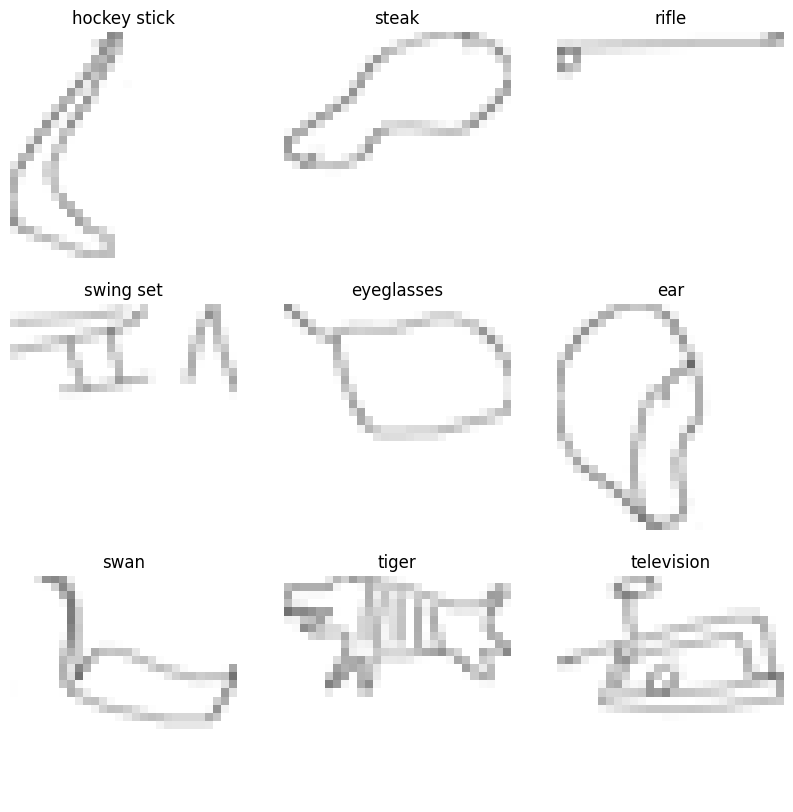

In [5]:
# plot 9 random hand drawings with its title from the training set
plt.figure(figsize=(10, 10))
for images, labels in train_ds.take(1):
    for i in range(9):
        ax = plt.subplot(3, 3, i + 1)
        data = images[i].numpy().astype("uint8")
        plt.imshow(data, cmap='gray', vmin=0, vmax=255)
        plt.title(train_ds.class_names[labels[i]])
        plt.axis("off")